## Data preprocessing

1. Cell 1 imports all the important libraries.
2. Cell 2 downloads the data. 
    - The module 'requests' is used to send HTTP requests.
       - We store the names of all the pokemons in full_names.
3. Cell 3 does all the important preprocessing tasks.
    - Firstly, digits and special symbols are removed using maketrans() and translate() functions.
    - After creating a set of the list of characters and words(to delete duplicates), two dictionaries char2int
      and int2char are created to assign each character an integer and vice-versa. This is going to help while creating 
      one hot vectors and also while training(to access ground truth labels).
4. After executing cell 4, we get the tensor with the help of which we can access characters.

In [1]:
import torch
import numpy as np
import requests
import string
from string import digits
from torch import nn
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

In [3]:
result = requests.get("https://pokeapi.co/api/v2/pokemon/?limit=1000").json()
full_names = [result['results'][i]['name'] for i in range(result['count'])]

In [4]:
li = []
chars = []
char2int = {}
int2char = {}


for namu in full_names:
    namu = namu.translate(str.maketrans('','',digits))
    if namu not in li:
        namu = namu.translate({ord(c): " " for c in "!@#$%^&*()[]{};:,./<>?\|`~-=_+"})
        li.append(namu)
        for i in namu:
            chars.append(i)
            
            
chars = set(chars)
li = set(li)


for j,char in enumerate(chars):
    char2int[char] = j
    int2char[j] = char

In [5]:
one_hots = torch.zeros(len(chars)+1,len(chars)+1)
for i in range(0,len(chars)):
    one_hots[i][char2int[int2char[i]]] = 1
    
vocab_size = len(set(chars))+1

## Model

- Our model is defined here. 
- Hidden nodes of fully connected layer is initialised to 1024. nn.LSTM() initialises it's hidden weights to zeros if it is 
   not sent as a parameter explicitly. Here we let it initialise it to zero by itself to make our life easier.
- Here our block is designed as one LSTM cell followed by a fully connected layer. We use Adam as our model's optimizer.
- Model().cuda() utilises GPU cores for training. 

In [15]:
class Model(nn.Module):
    def __init__(self, hidden_size=1024,vocab_size=28):
        super(Model, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(vocab_size, hidden_size, batch_first=True, bidirectional=False) 
        
        self.fc = nn.Linear(hidden_size,vocab_size)

    def forward(self, x):
        output, hidden = self.lstm(x)    
        out = self.fc(output)
        return out,hidden
    

In [16]:
net = Model().cuda()
optimizer = torch.optim.Adam(net.parameters())
lossfn= nn.CrossEntropyLoss() 

## Training 

- nn.LSTM expects it's parameters in a certain manner. We use .unsqueeze() to make sure we get the correct dimension.
- Loss is printed after every epoch.
- We append every loss to the costs list and plot the graph at the end of our training. It helps in understanding how our model is performing. 

In [8]:
costs = []
epochs = 20

for i in range(epochs):
    
    for names in li:
            
        for number,letter in enumerate(names):
            
            inputs = one_hots[char2int[letter]]
            inputs = torch.unsqueeze(torch.unsqueeze(inputs,0),0)
            output, hidden = net(inputs.cuda())
            
            if(number==len(names)-1):
                ytarget = torch.tensor([27],dtype=torch.int64)
            
            else:
                ytarget = torch.tensor([char2int[names[number+1]]], dtype = torch.int64)

            output = output.view(1,-1)
            
            loss = lossfn(output.cuda(),ytarget.cuda())
            costs.append(loss)
            
            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
            
            if(number==len(names)):
                break
        
    print(loss.item())
                
print('end')

1.9772729873657227
1.985729694366455
1.9703121185302734
1.9516973495483398
1.9348889589309692
1.9204928874969482
1.909008264541626
1.9004110097885132
1.8942530155181885
1.8898963928222656
1.8865076303482056
1.8835840225219727
1.8808891773223877
1.8784518241882324
1.8763799667358398
1.8745813369750977
1.8730289936065674
1.8719617128372192
1.8715084791183472
1.8715498447418213
end


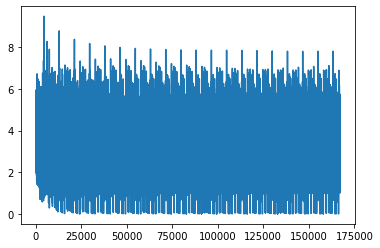

In [9]:
plt.plot(costs)

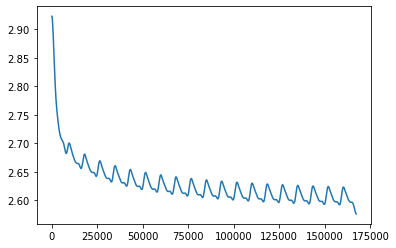

In [12]:
cost = [float(i.cpu().detach()) for i in costs]
smooth = gaussian_filter(cost,sigma=900)
plt.plot(smooth)

## Some observations

- The loss shown remains more or less same because it represents the loss corresponding to the last character of the last word. But there are no set of rules that dictate how letters should occur in a pokemon's name so our model never really learns what to predict. But the graph shows that it does learn some patterns, maybe something like how vowels are important and how to use it. 
- The first graph makes it really difficult to infer anything since our training is very stochastic in nature. So we use a  gaussian filter to help understand the trend of the loss graph.
- In the second graph we see (20)bumps in the graph. Each bump corresponds to an epoch. So we can now understand that after every epoch our model gets better at predicting characters but it seems that after a point it will take a long time to see any significant improvement in our model.